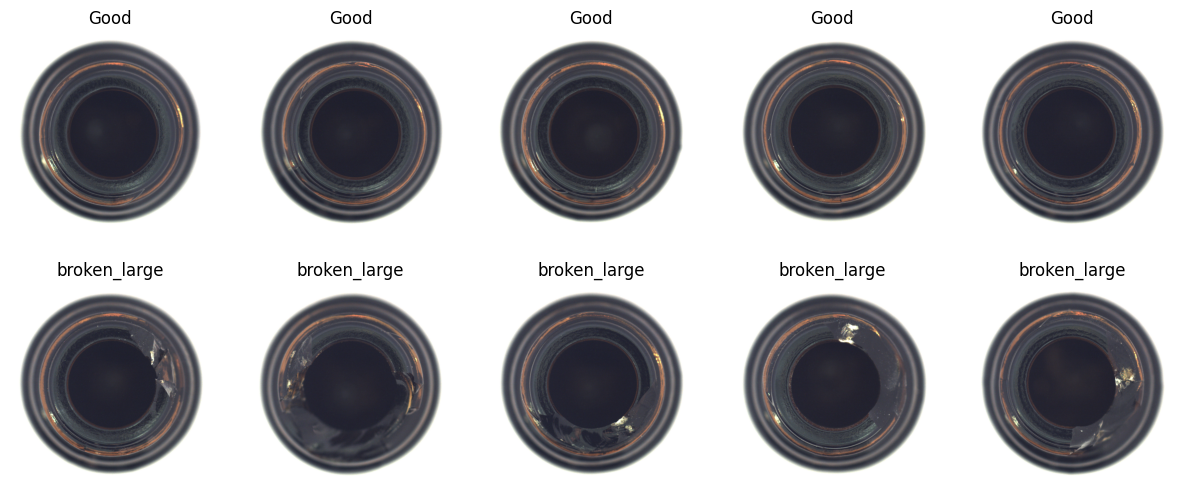

In [1]:
import os
import matplotlib.pyplot as plt
import random

from mpl_toolkits.mplot3d.proj3d import transform


def display_good_and_anomalous_images(base_path, anomaly_type, num_images=5):
    """
    Displays a mix of 'good' and 'anomalous' images from the specified MVTec category.
    
    Parameters:
    - base_path (str): Base path to the MVTec dataset.
    - category (str): The category (e.g., "bottle", "capsule") to display images from.
    - anomaly_type (str): The specific type of anomaly (e.g., "broken_large", "contamination").
    - num_images (int): Number of images to display for each type (good and anomalous).
    """
    # Paths to good and anomalous images
    good_path = os.path.join(base_path, "train", "good")
    anomaly_path = os.path.join(base_path, "test", anomaly_type)

    # List all images in the directories
    good_images = os.listdir(good_path)
    anomaly_images = os.listdir(anomaly_path)

    # Randomly select images to display
    selected_good_images = random.sample(good_images, min(num_images, len(good_images)))
    selected_anomaly_images = random.sample(anomaly_images, min(num_images, len(anomaly_images)))

    # Plot the images
    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))
    
    # Display good images
    for i, img_name in enumerate(selected_good_images):
        img_path = os.path.join(good_path, img_name)
        img = plt.imread(img_path)
        axes[0, i].imshow(img)
        axes[0, i].axis("off")
        axes[0, i].set_title("Good")

    # Display anomalous images
    for i, img_name in enumerate(selected_anomaly_images):
        img_path = os.path.join(anomaly_path, img_name)
        img = plt.imread(img_path)
        axes[1, i].imshow(img)
        axes[1, i].axis("off")
        axes[1, i].set_title(anomaly_type)

    plt.show()

base_path = "bottle/bottle" # cooked path
display_good_and_anomalous_images(base_path,  anomaly_type="broken_large", num_images=5)


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import roc_auc_score




In [2]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim=32*32*3, hidden_dim=2):
        super(AutoEncoder, self).__init__()
        # Encoder 
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, input_dim // 2),
            nn.ReLU(),
            nn.Linear(input_dim // 2, input_dim // 4),
            nn.ReLU(),
            nn.Linear(input_dim // 4, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, input_dim // 4),
            nn.ReLU(),
            nn.Linear(input_dim // 4, input_dim // 2),
            nn.ReLU(),
            nn.Linear(input_dim // 2, input_dim),
            nn.Sigmoid(),
            nn.Unflatten(1,(3, 32, 32))
        )

    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return decode




In [3]:
class MVTecDataset(Dataset):
    def __init__(self, root_dir, transform, is_train):
        """
        Args:
            root_dir (str): Root directory of MVTec AD dataset
            category (str): Category name (e.g., 'bottle', 'cable', etc.)
            is_train (bool): If True, load training data, else test data
            transform: transform to be applied on images
        """
        self.root_dir = root_dir
        self.is_train = is_train
        self.transform = transform
        
        # Set up paths
        if is_train:
            self.image_paths = self._get_image_paths('train/good')
        else:
            self.image_paths = self._get_image_paths('test/good')
            self.image_paths.extend(self._get_defect_image_paths('test'))
            
    def _get_image_paths(self, subset):
        path = os.path.join(self.root_dir, subset)
        if not os.path.exists(path):
            return []
        return [os.path.join(path, f) for f in os.listdir(path) if f.endswith(('.png', '.jpg'))]
    
    def _get_defect_image_paths(self, subset):
        paths = []
        defect_types = ["broken_large", "broken_small", "contamination"]
        
        for defect in defect_types:
            defect_path = os.path.join(self.root_dir, subset, defect)
            paths.extend([os.path.join(defect_path, f) for f in os.listdir(defect_path)])
        return paths
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        #image = image / 255.0
        # 1 for good; 0 for defect
        label = 1 if 'good' in img_path else 0
        return image, label


In [4]:
# Path to 'good' training images for bottle category
path = "bottle/bottle/"


transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.229, 0.224, 0.225))
])

train_dataset = MVTecDataset(path, transform, is_train=True)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

test_dataset = MVTecDataset(path, transform, is_train=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)



In [5]:
def train_autoencoder(model, train_loader, num_epochs, learning_rate=1e4, device='cpu', debug=False):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    losses = []
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        #tqdm gives nice terminal display
        for batch_data, _ in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            data = batch_data.to(device)
            reconstructed = model(data)
            if debug:
                print(f"Data shape = {data.shape}")
                print(f"Reconstructed shape = {reconstructed.shape}")
            loss = criterion(reconstructed, data)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
        losses.append(total_loss)
    return losses

cuda


Epoch 5/5: 100%|██████████| 27/27 [00:03<00:00,  7.82it/s]


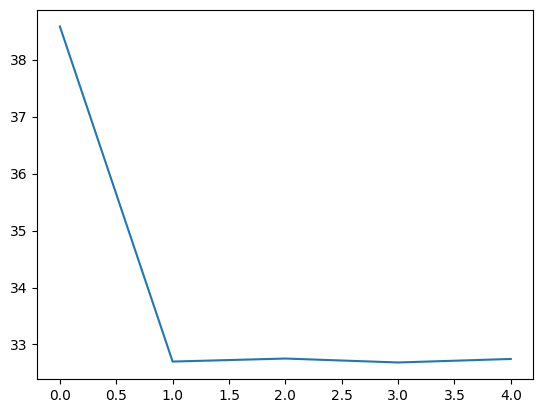

In [6]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
LR = 0.001
ae = AutoEncoder().to(device)
optimizer = optim.Adam(ae.parameters(), lr=LR)

losses = train_autoencoder(ae, train_loader, num_epochs=5, learning_rate=LR, device=device)
plt.plot(losses)


In [7]:
def get_anomaly_value(model, test_loader, device='cuda'):
    model.eval()
    
    good_errors = []
    anomaly_errors = []
    good_count = 0
    anomaly_count = 0
    
    with torch.no_grad():
        for batch_data, batch_labels in test_loader:
            data = batch_data.to(device)
            labels = batch_labels.to(device)
            
            reconstructed = model(data)
            
            # not rly sure this is the correct way to do it
            errors = torch.mean((data - reconstructed) ** 2, dim=(1,2,3))
            
            good_mask = labels == 1
            anomaly_mask = labels == 0
            
            good_errors.extend(errors[good_mask].cpu().numpy())
            anomaly_errors.extend(errors[anomaly_mask].cpu().numpy())
            
            good_count += good_mask.sum().item()
            anomaly_count += anomaly_mask.sum().item()
    
    good_errors = np.array(good_errors)
    anomaly_errors = np.array(anomaly_errors)
    seperator = (good_errors.sum() + anomaly_errors.sum()) / (good_count + anomaly_count)
    return seperator

anomaly_threshold = get_anomaly_value(ae, test_loader)
print(anomaly_threshold)


1.173912967544004


In [8]:
def get_predictions(model, loader, threshold, device='cuda', return_all_images=False):

    model.eval()
    all_images = []
    predictions = []
    true_labels = []
    reconstruction_errors = []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            reconstructed = model(images)
            if return_all_images:
                all_images.extend(images.cpu())
            # Calculate reconstruction error (MSE) for each image
            error = torch.mean((images - reconstructed) ** 2, dim=(1, 2, 3))
            reconstruction_errors.extend(error.cpu().numpy())
            
            # Classify as anomaly if reconstruction error > threshold
            pred = (error <= threshold).float()
            predictions.extend(pred.cpu().numpy())
            
            # Convert labels to binary (1: good, 0: anomaly)
            true_labels.extend(labels.float().cpu().numpy())
    
    # Convert lists to numpy arrays
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    reconstruction_errors = np.array(reconstruction_errors)
    if return_all_images:
        return all_images, predictions, true_labels, reconstruction_errors
    return predictions, true_labels, reconstruction_errors


all_images, p, t, r = get_predictions(ae, test_loader, anomaly_threshold, device, True)

print(f"accuracy = {np.mean(p == t)}")



accuracy = 0.4939759036144578


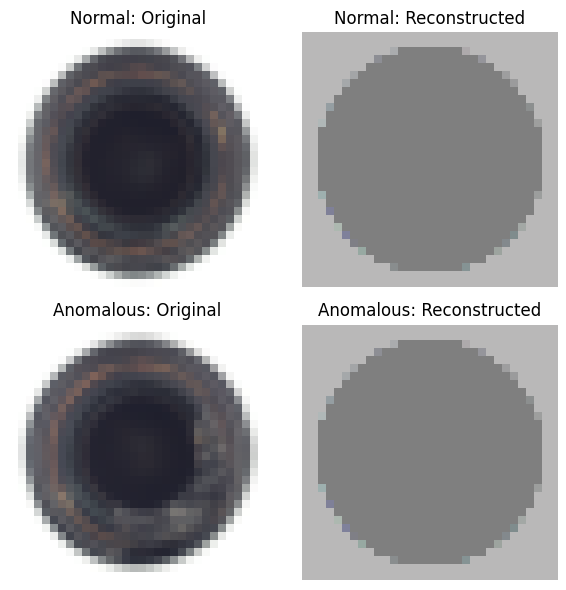

In [9]:
def plot_original_and_reconstructed_with_anomalies(model, data_loader, device, num_images=1):
    """
    Plot original and reconstructed images side by side, including anomalous images.
    
    Args:
        model: Trained autoencoder model.
        data_loader: DataLoader providing the images and labels.
        device: Device where the model is located ('cuda' or 'cpu').
        num_images: Number of images to display for both normal and anomalous images.
    """
    model.eval()  # Set the model to evaluation mode
    normal_images = []
    normal_reconstructions = []
    anomalous_images = []
    anomalous_reconstructions = []

    # Get a single batch of images and filter normal and anomalous samples
    with torch.no_grad():
        for batch_data, labels in data_loader:
            batch_data = batch_data.to(device)
            reconstructed = model(batch_data)
            batch_data = batch_data.cpu().numpy()
            reconstructed = reconstructed.cpu().numpy()
            labels = labels.cpu().numpy()
            
            # Separate normal and anomalous images
            for i in range(len(labels)):
                if labels[i] == 1 and len(normal_images) < num_images:
                    normal_images.append(denormalize(batch_data[i]))
                    normal_reconstructions.append(denormalize(reconstructed[i]))
                elif labels[i] == 0 and len(anomalous_images) < num_images:
                    anomalous_images.append(denormalize(batch_data[i]))
                    anomalous_reconstructions.append(denormalize(reconstructed[i]))
            
            # Break if we have enough samples for both categories
            if len(normal_images) >= num_images and len(anomalous_images) >= num_images:
                break
    
    # Plot the images
    fig, axes = plt.subplots(num_images * 2, 2, figsize=(6, num_images * 6))
    for i in range(num_images):
        # Normal images
        axes[2 * i, 0].imshow(normal_images[i].transpose(1, 2, 0))  # CHW to HWC
        axes[2 * i, 0].set_title("Normal: Original")
        axes[2 * i, 0].axis('off')

        axes[2 * i, 1].imshow(normal_reconstructions[i].transpose(1, 2, 0))  # CHW to HWC
        axes[2 * i, 1].set_title("Normal: Reconstructed")
        axes[2 * i, 1].axis('off')
        
        # Anomalous images
        axes[2 * i + 1, 0].imshow(anomalous_images[i].transpose(1, 2, 0))  # CHW to HWC
        axes[2 * i + 1, 0].set_title("Anomalous: Original")
        axes[2 * i + 1, 0].axis('off')

        axes[2 * i + 1, 1].imshow(anomalous_reconstructions[i].transpose(1, 2, 0))  # CHW to HWC
        axes[2 * i + 1, 1].set_title("Anomalous: Reconstructed")
        axes[2 * i + 1, 1].axis('off')

    plt.tight_layout()
    plt.show()

def denormalize(image):
    mean = (0.5, 0.5, 0.5)
    std = (0.229, 0.224, 0.225)
    # Reverse the normalization
    im = torch.from_numpy(image)
    for t, m, s in zip(im, mean, std):
        t.mul_(s).add_(m)  # t = (t * std) + mean
    return im.numpy()

        
plot_original_and_reconstructed_with_anomalies(ae, test_loader, device)

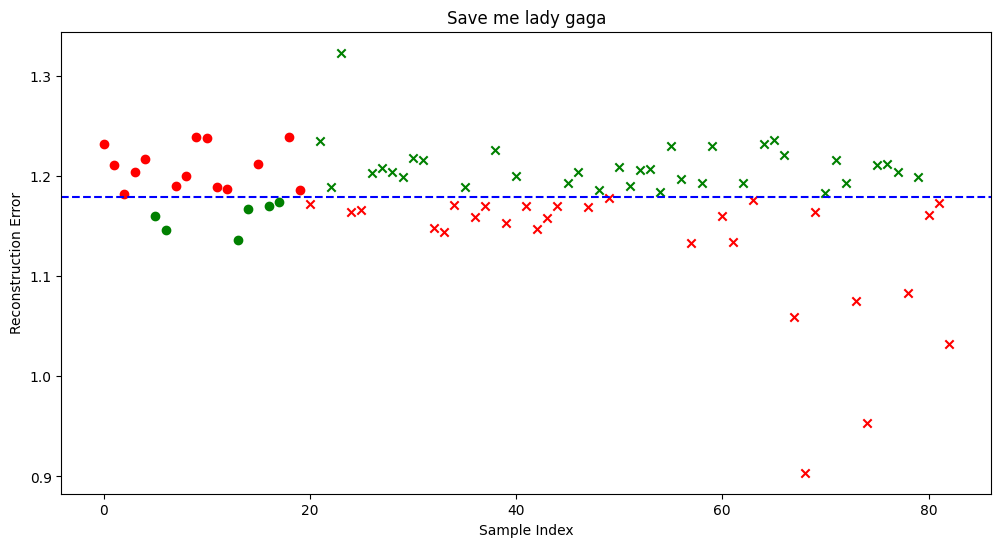

In [35]:
def plot_reconstruction_error1(threshold, recon_error, labels, pred ):
    reconstruction_errors = np.array(recon_error)
    labels = np.array(labels)
    predictions = np.array(pred)
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for idx, (error, label, prediction) in enumerate(zip(reconstruction_errors, labels, predictions)):
        # Correct classification
        if label == prediction:
            color = 'green'
        else:  # Misclassification
            color = 'red'
        
        # Marker style: 'o' for "good" and 'x' for "anomaly"
        marker = 'o' if label == 1 else 'x'
        
        ax.scatter(idx, error, c=color, marker=marker, label=f"{'Good' if label == 1 else 'Anomaly'}")
    
    # Threshold line
    ax.axhline(y=threshold, color='blue', linestyle='--', label='Threshold')
    
    # Labels and legend
    ax.set_title("Save me lady gaga")
    ax.set_xlabel("Sample Index")
    ax.set_ylabel("Reconstruction Error")

    plt.show()
    
plot_reconstruction_error1(anomaly_threshold, r, t, p)
# X = anomaly; O = good
# Green = correctly classified; Red = Incorrectly

In conclusion, the model fking sucks

In [18]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=2),  # (4x4 conv, stride=2)
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=4, stride=2, padding=2),  # (4x4 conv, stride=2)
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=4, stride=2, padding=2),  # (4x4 conv, stride=2)
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),  # (3x3 conv, stride=1)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=2),  # (4x4 conv, stride=2)
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # (3x3 conv, stride=1)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=2),  # (4x4 conv, stride=2)
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),  # (3x3 conv, stride=1)
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),  # (3x3 conv, stride=1)
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=8, stride=1, padding=3),  # (8x8 conv, stride=1)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),  # (1x1 -> 2x2)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),  # (2x2 -> 4x4)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # (4x4 -> 8x8)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1),  # (8x8 -> 16x16)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1),  # (16x16 -> 32x32)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # (32x32 -> 64x64)
            nn.Sigmoid(),  # Normalize output to range [0, 1]
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Epoch 20/20: 100%|██████████| 27/27 [00:03<00:00,  8.01it/s]


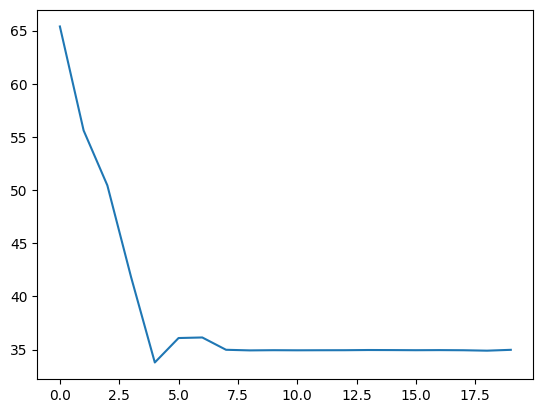

In [19]:
conv_ae = ConvAutoEncoder().to(device)

conv_losses = train_autoencoder(conv_ae, train_loader, num_epochs=20, learning_rate=LR, device=device)
plt.plot(conv_losses)

Normal AE Threshold value = 1.1796292224562313
ConvAE Threshold value    = 1.2578416387718845
AE Accuracy     = 0.4939759036144578
ConvAE Accuracy = 0.46987951807228917
they both suck wtf


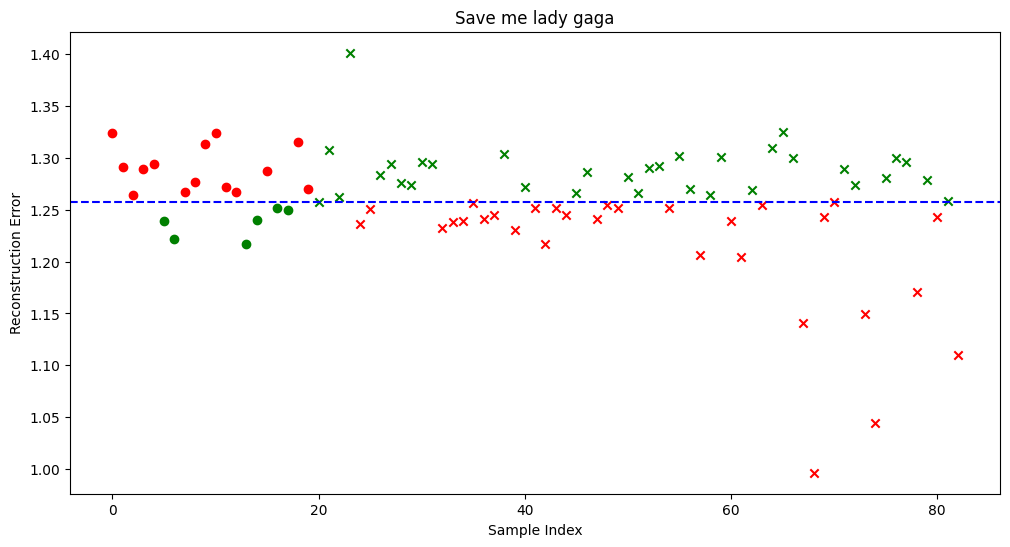

In [20]:
conv_anomaly_treshold = get_anomaly_value(conv_ae, test_loader)
print(f"Normal AE Threshold value = {anomaly_threshold}\nConvAE Threshold value    = {conv_anomaly_treshold}")
p_conv, t_conv, r_conv = get_predictions(conv_ae, test_loader, conv_anomaly_treshold, device)
print(f"AE Accuracy     = {np.mean(p== t)}\nConvAE Accuracy = {np.mean(p_conv == t_conv)}")
print("they both suck wtf")
plot_reconstruction_error1(conv_anomaly_treshold, r_conv, t_conv, p_conv)


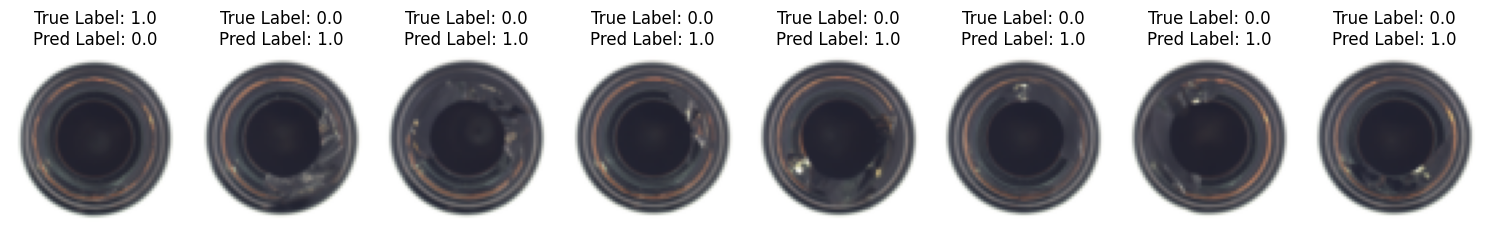

In [35]:
def get_missclassified_images(images, predicted_labels, true_labels):
    miss_class_img = []
    true = []
    predicted = []
    for img, true_label, pred_label in zip(images, true_labels, predicted_labels):
        if true_label != pred_label:
            miss_class_img.append(img)
            true.append(true_label)
            predicted.append(pred_label)

    return miss_class_img, true, predicted


def display_images(images, true_labels, predicted_labels, n=8):

    n = min(n, len(images))  # Ensure n is not greater than the number of images
    if n == 0:
        print("No misclassified images to display.")
        return
    
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    for i, ax in enumerate(axes):
        img = images[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy and rearrange dimensions
        true_label = true_labels[i]
        predicted_label = predicted_labels[i]
        
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"True Label: {true_label}\nPred Label: {predicted_label}")
    
    plt.tight_layout()
    plt.show()

display_images(*get_missclassified_images(all_images, p, t))